In [30]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import misc, ndimage
import PIL
from PIL import Image
from PIL import ImageOps
import IPython.display as dp

In [31]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.preprocessing import image, sequence
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

In [32]:
K.set_image_dim_ordering('tf')

In [33]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

In [34]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [35]:
# collect all .png files in working dir
fs = !ls Pokemon *.jpg
fs = fs[2:]

In [36]:
def load_image(file_name) :
    img = Image.open(file_name)
    img.load()
    data = np.asarray(img)
    return data

In [37]:
# create list of image objects
poke_imgs = []
for name in fs:
    poke_imgs.append(load_image('Pokemon/' + name))

Design the image generator

In [38]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, horizontal_flip=True)

Expand the images to be (x_dim, y_dim, 3)

In [39]:
# Create a 'batch' images
valid_imgs = []
for poke_img in poke_imgs:
    valid_imgs.append(np.expand_dims(poke_img, 0))# Request the generator to create batches from this image

Create list of images augmented images

In [40]:
# Request the generator to create batches from this image
poke_imgs_iter = []
for valid_img in valid_imgs:
    poke_imgs_iter.append(gen.flow(valid_img))

In [41]:
# Get eight examples of these augmented images
train_imgs = []
for poke_img_iter in poke_imgs_iter:
    for i in range(4):
        train_imgs.append(next(poke_img_iter)[0].astype(np.uint8))

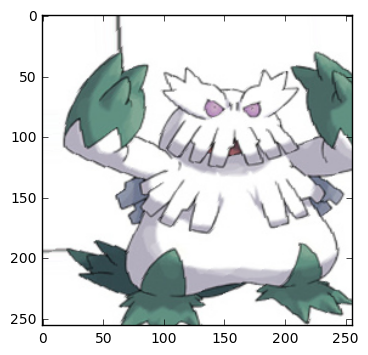

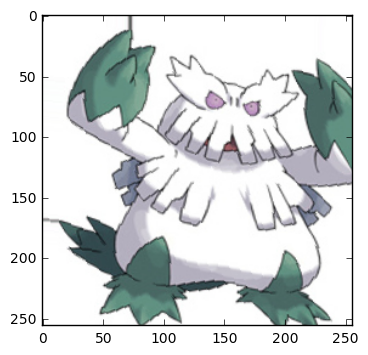

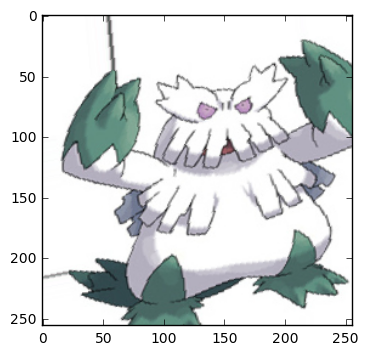

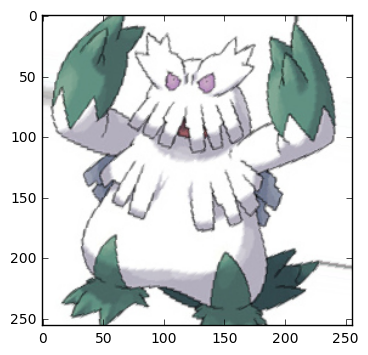

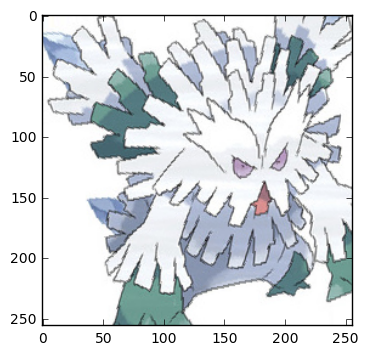

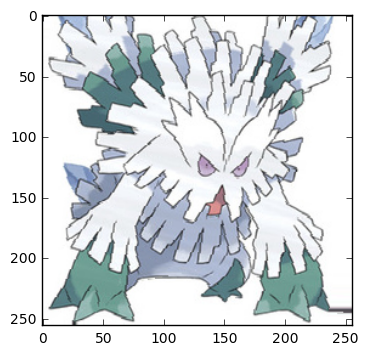

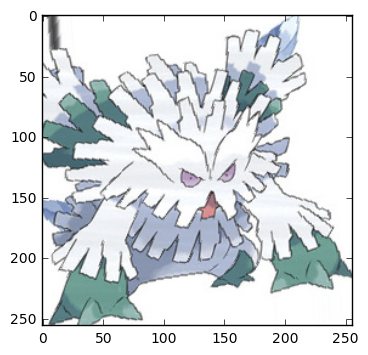

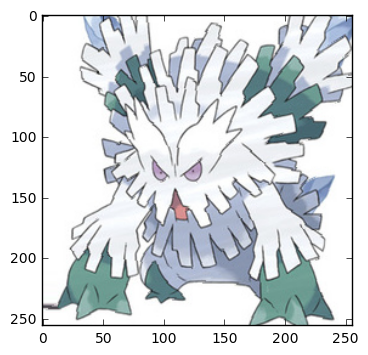

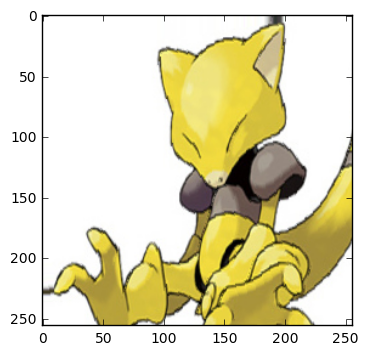

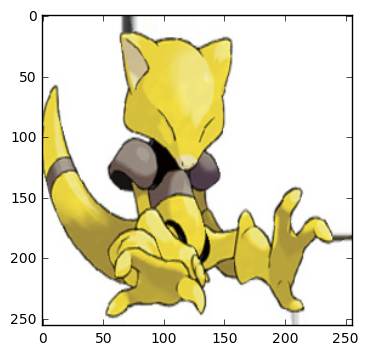

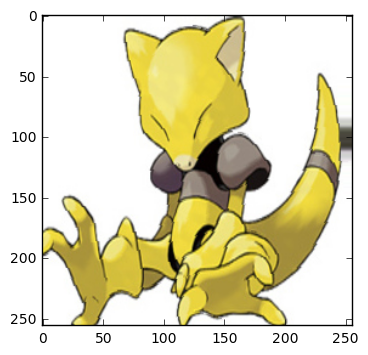

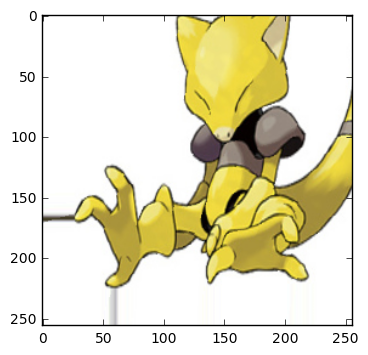

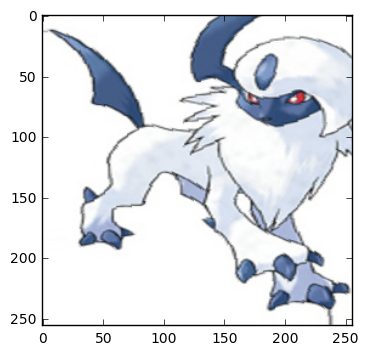

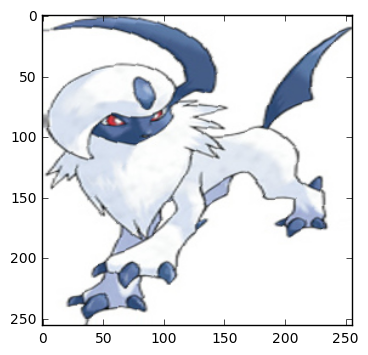

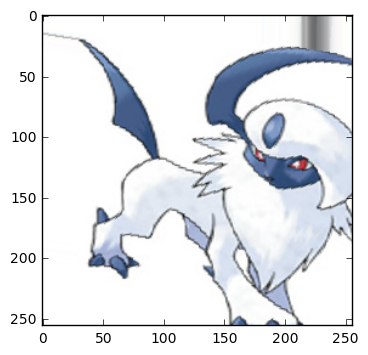

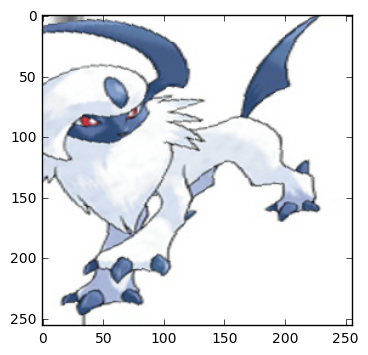

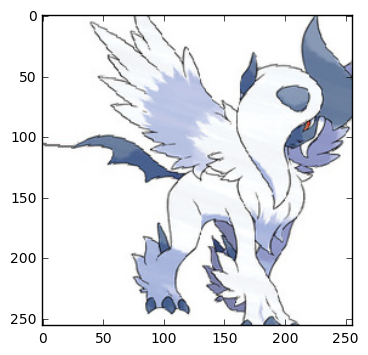

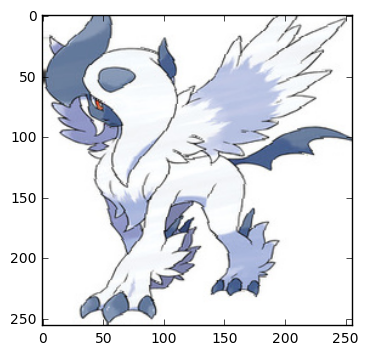

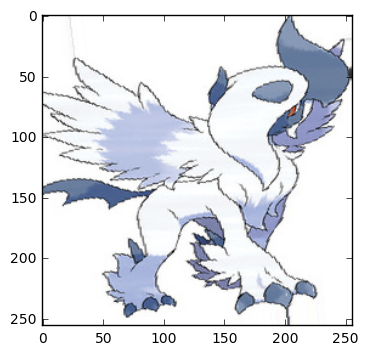

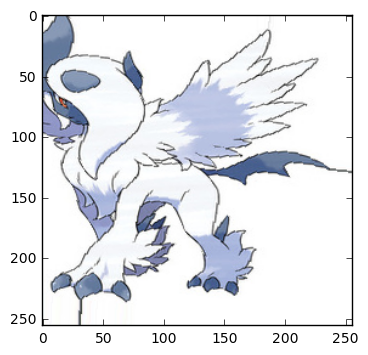

In [42]:
for i in range(20):
    plt.imshow(train_imgs[i])
    plt.show()

In [43]:
val_labels = []
for name in fs:
    val_labels.append(name[0:-4])

In [44]:
tra_labels = val_labels*4
tra_labels.sort()

In [45]:
X_train = []
for image in train_imgs:
    X_train.append((image.astype(np.float32) - 127.5)/127.5)
y_train = tra_labels

X_test = []
for image in valid_imgs:
    X_test.append((image.astype(np.float32) - 127.5)/127.5)
y_test = val_labels

In [17]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [46]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [47]:
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [48]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(3, 256, 256), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [49]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

ValueError: number of input channels does not match corresponding dimension of filter, 1 != 256

In [ ]:
dLosses = []
gLosses = []

In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

In [ ]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=20, dim=(20, 20), figsize=(20, 20)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

In [ ]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

In [ ]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
                        # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

In [ ]:
if __name__ == '__main__':
    train(50, 128)